In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\CT")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\3DTomoGAN")
from plots import *
import os
import utils
import h5py
from scipy.optimize import curve_fit
from PIL import Image

import scipy.ndimage as nd

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patheffects as PathEffects

%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [5]:
root = r"C:\Users\Bruker\Documents\4DCT"
choose_formatter(False)

In [6]:
# Load .npy files

x1, x2 = 672, 928
y1, y2 = 384, 640
z1, z2 = 384, 640

slice = [[x1, x2], [y1, y2], [z1, z2]]

names = [
    "hourglassV3_13_55",
]

crossections = {
    # "favg6":  {"name": names[0] },
    # "favg12": { "name": names[1]},
    # "favg24": {"name": names[2]},
}

identifiers = [
    "gt",
    "Rec_0_1_fdk",
    "Rec_0_3_fdk",
    "Rec_0_5_fdk",
    "Rec_0_8_fdk",
    "Rec_0_1_fdk_enhanced_800512512",
    "Rec_0_3_fdk_enhanced_800512512",
    "Rec_0_5_fdk_enhanced_800512512",
    "Rec_0_8_fdk_enhanced_800512512",

]
keys = [
    "gt",
    "13",
    "39",
    "65",
    "104",
    "13_enhanced",
    "39_enhanced",
    "65_enhanced",
    "104_enhanced",
]

# for k, v in crossections.items():
for j,(id,key) in enumerate(zip(identifiers, keys)):

    if key.endswith("enhanced"):
        x1, x2 = 0,256
        y1, y2 = 0,256
        z1, z2 = 0,256
    else:
        x1, x2 = 672, 928
        y1, y2 = 384, 640
        z1, z2 = 384, 640

    load_name = f"{names[0]}_{identifiers[j]}_{x1}_{x2}_{y1}_{y2}_{z1}_{z2}.npy"
    load_path = os.path.join(root, load_name)
    crossections[key]= np.squeeze(np.load(load_path))

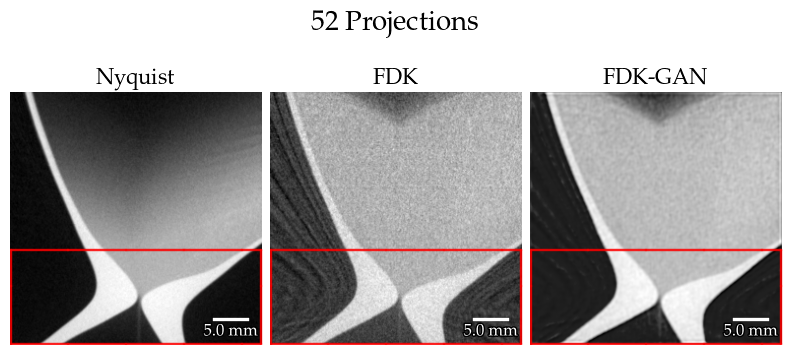

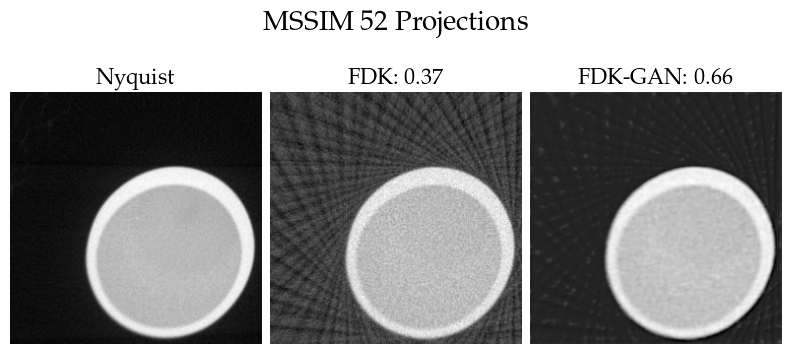

In [38]:
slice_norm = lambda x, ref : x* (np.max(ref) - np.min(ref)) + np.min(ref)
slgt = ( crossections["gt"][:,:,180] )#- np.min(crossections["gt"]) ) / ( np.max(crossections["gt"]) - np.min(crossections["gt"]) )
slin = ( crossections["39"][:,:,180] )#- np.min(crossections["39"]) ) / ( np.max(crossections["39"]) - np.min(crossections["39"]) )
slout = slice_norm(crossections["39_enhanced"][:,:,180], crossections["gt"]) # - np.min(crossections["39_enhanced"]) / ( np.max(crossections["39_enhanced"]) - np.min(crossections["39_enhanced"]) )

ssin, _ = evaluate(slgt, slin, normalise=False)
ssout,_ = evaluate(slgt, slout, normalise=False)

varin = None
varout = None #RSD: New metric.

mask = [[160, i] for i in range(256)]
mask.extend([[255, i] for i in range(256)])
mask.extend([[i, 1] for i in range(160,256)])
mask.extend([[i, 255] for i in range(160,256)])
mask = np.array(mask).T

plot_slice_grid(
    [slgt, slin, slout],
    ["Nyquist", f"FDK", f"FDK-GAN"],
    bar=True,
    scalebar_kwargs = scale_kwargs,
    folder ="Hourglass4D",
    suptitle="52 Projections",
    savefig=True,
    savefile="Hourglass4D_39_projections",
    mask=mask,
    fs = (1,2))

#RSD: Red line is crossection. Inside rec box is MSSIM and PSNR score for total. 

h = 160 

slgt = (crossections["gt"][h]) # - np.min(crossections["gt"])) / ( np.max(crossections["gt"]) - np.min(crossections["gt"]) )
slin = (crossections["39"][h]) # - np.min(crossections["39"])) / ( np.max(crossections["39"]) - np.min(crossections["39"]) )
slout = slice_norm( crossections["39_enhanced"][h], crossections["gt"]) #- np.min(crossections["39_enhanced"])) / ( np.max(crossections["39_enhanced"]) - np.min(crossections["39_enhanced"]) )

ssin, _ = utils.calc_mssim(slgt, slin) #evaluate(slgt, slin, normalise=False)
ssout,_ = utils.calc_mssim(slgt, slout) #evaluate(slgt, slout, normalise=False)


plot_slice_grid(
    [slgt, slin, slout],
    ["Nyquist", f"FDK: {ssin:.2f}", f"FDK-GAN: {ssout:.2f}"],
    bar=False,
    folder ="Hourglass4D",
    suptitle="MSSIM 52 Projections",
    savefig=True,
    savefile="Hourglass4D_crossection_39_projections",
    fs = (1,2))


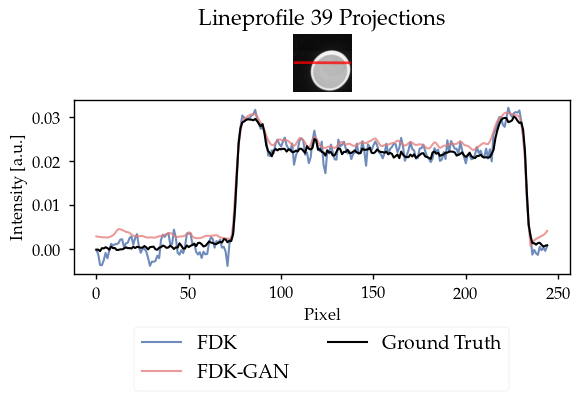

In [23]:
# Line profile

input_norm = (crossections["39"][h])#- np.min(crossections['39'])) / (np.max(crossections["39"]) - np.min(crossections['39']))
gt_norm = (crossections["gt"][h])#- np.min(crossections['gt'])) / (np.max(crossections["gt"]) - np.min(crossections['gt']))
output_norm = slice_norm(crossections["39_enhanced"][h], crossections["gt"])#- np.min(crossections['39_enhanced'])) / (np.max(crossections["39_enhanced"]) - np.min(crossections['39_enhanced']))

imgs = [input_norm, output_norm]
labels = ["FDK", "FDK-GAN"]
plot_line_profile(imgs, labels, gt_norm, idxs= [128, 129, 10,255], folder="Hourglass4D", title="Lineprofile 39 Projections", savefig=True, savefile="Hourglass4D_line_profile_39_projections")


# fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
# ax1.xcorr(gt_norm[128].flatten(), input_norm[128].flatten(), usevlines=True, maxlags=None, normed=False)
# ax2.xcorr(gt_norm[128].flatten(), output_norm[128].flatten(), usevlines=True, maxlags=None, normed=False)
# plt.show()

FDK: 23.83
-0.009770108 0.008704074
FDK-GAN: 22.44
-0.005372666 0.008290851


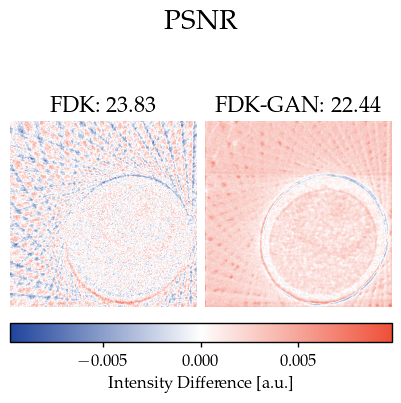

In [28]:
slgt = (crossections["gt"][h] )#- np.min(crossections["gt"]) ) / (np.max(crossections["gt"]) - np.min(crossections["gt"]))
slin = (crossections["39"][h] )#- np.min(crossections["39"]) ) / (np.max(crossections["39"]) - np.min(crossections["39"]))
slout = slice_norm(crossections["39_enhanced"][h], crossections["gt"]) #- np.min(crossections["39_enhanced"]) ) / (np.max(crossections["39_enhanced"]) - np.min(crossections["39_enhanced"]))

_, psin = evaluate(slgt, slin, normalise=False)
_,psout = evaluate(slgt, slout, normalise=False)

import matplotlib as mpl
plot_slice_grid(
    [ -slgt+slin, -slgt+slout],
    [f"FDK: {psin:.2f}", f"FDK-GAN: {psout:.2f}"],
    bar=False,
    folder ="Hourglass4D",
    suptitle="PSNR",
    savefig=True,
    savefile="Hourglass4D_crossection_difference_39_projections",
    cm=XRDCT_diverging_cmp,
    two_sided=True,
    fs=(1,1))

# fig = plt.figure()

# gs = fig.add_gridspec(3, 4)
# ax1 = fig.add_subplot(gs[0:2, 0:2])
# ax2 = fig.add_subplot(gs[0:2, 2:4])
# ax3 = fig.add_subplot(gs[2, :])
# cmap = "gray"

# vmin = np.min([np.min(slgt-slin), np.min(slgt-slout)])
# vmax = np.max([np.max(slgt-slin), np.max(slgt-slout)])
# im1=ax1.imshow(slgt-slin, cmap=cmap, vmin=vmin, vmax=vmax)
# ax1.set_title(f"Input PSNR: {psin:.2f}")
# ax1.axis("off")

# im=ax2.imshow(slgt-slout, cmap=cmap, vmin=vmin, vmax=vmax)
# ax2.set_title(f"Output PSNR: {psout:.2f}")
# ax2.axis("off")

# # im1.set_clim(-1,1)


# norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax3, orientation="horizontal")


# # fig.colorbar(im1, cmap=cmap, ax=ax3, orientation="horizontal")# NOT WORKING
# # plt.colorbar(im1)
# plt.show()


In [29]:
identifiers_it = [
    "gt",
    "Rec_0_1_sirt",
    "Rec_0_3_sirt",
]
keys_it = [
    "gt",
    "13",
    "39",]

it_crossections = {}

# for k, v in crossections.items():
for j,(id,key) in enumerate(zip(identifiers_it, keys_it)):

    if key.endswith("enhanced"):
        x1, x2 = 0,256
        y1, y2 = 0,256
        z1, z2 = 0,256
    else:
        x1, x2 = 672, 928
        y1, y2 = 384, 640
        z1, z2 = 384, 640

    load_name = f"{names[0]}_{identifiers_it[j]}_{x1}_{x2}_{y1}_{y2}_{z1}_{z2}{'' if key=='gt' else '_it100' }.npy"
    load_path = os.path.join(root, load_name)
    it_crossections[key]= np.squeeze(np.load(load_path))

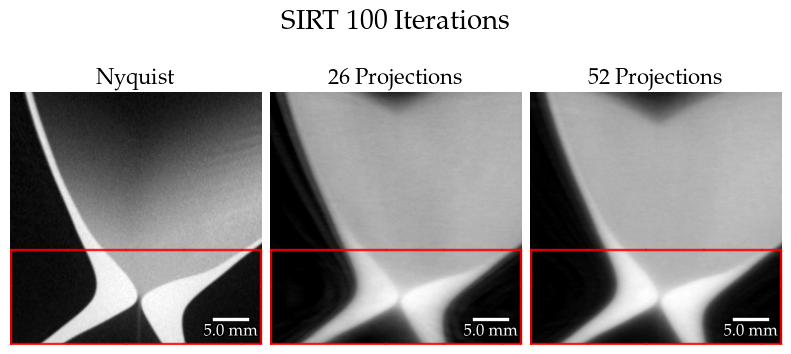

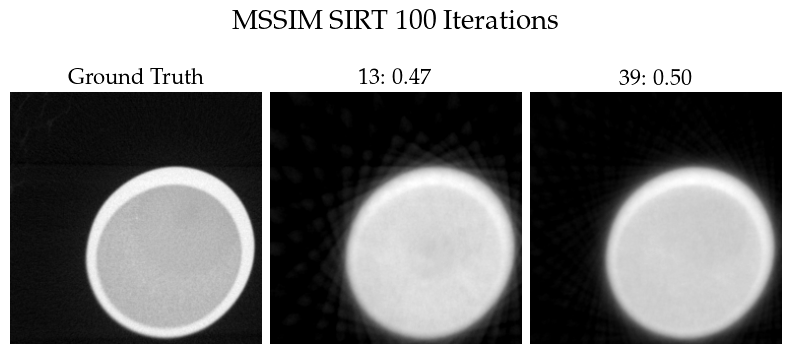

In [41]:
itgt = (it_crossections["gt"][:,:,180])# - np.min(it_crossections["gt"])) / (np.max(it_crossections["gt"]) - np.min(it_crossections["gt"]))
itin = (it_crossections["13"][:,:,180])# - np.min(it_crossections["13"])) / (np.max(it_crossections["13"]) - np.min(it_crossections["13"]))
itout= (it_crossections["39"][:,:,180])# - np.min(it_crossections["39"])) / (np.max(it_crossections["39"]) - np.min(it_crossections["39"]))

itssin, _ = utils.calc_mssim(itgt, itin) #evaluate(itgt, itin, normalise=False)
itssout,_ = utils.calc_mssim(itgt, itout) #evaluate(itgt, itout, normalise=Falseout

scale_kwargs = {
    "size": 5 / (0.2 * 930) * 1350,
    "label": f"5.0 mm",
    "color": "white",
    "loc": 4,
    "frameon": False,
    "size_vertical": 3,
    "label_top": False,
    # "font_properties": {"size": 16}
}

plot_slice_grid(
    [itgt, itin, itout],
    ["Nyquist", f"26 Projections", f"52 Projections"],
    bar=True,
    scalebar_kwargs=scale_kwargs,
    mask=mask,
    folder ="Hourglass4D",
    suptitle="SIRT 100 Iterations",
    savefig=True,
    savefile="Hourglass4D_SIRT",
    fs = (1,2),)

h = 160 

itgt = (it_crossections["gt"][h])# - np.min(it_crossections["gt"])) / (np.max(it_crossections["gt"]) - np.min(it_crossections["gt"]))
itin = (it_crossections["13"][h])# - np.min(it_crossections["13"])) / (np.max(it_crossections["13"]) - np.min(it_crossections["13"]))
itout =( it_crossections["39"][h])# - np.min(it_crossections["39"])) / (np.max(it_crossections["39"]) - np.min(it_crossections["39"]))

itssin, _ = utils.calc_mssim(itgt, itin) #evaluate(itgt, itin, normalise=False)
itssout,_ = utils.calc_mssim(itgt, itout) #evaluate(itgt, itout, normalise=Falseout


plot_slice_grid(
    [itgt, itin, itout],
    ["Ground Truth", f"13: {itssin:.2f}", f"39: {itssout:.2f}"],
    bar=False,
    folder ="Hourglass4D",
    suptitle="MSSIM SIRT 100 Iterations",
    savefig=True,
    savefile="Hourglass4D_crossection_SIRT",
    fs = (1,2))

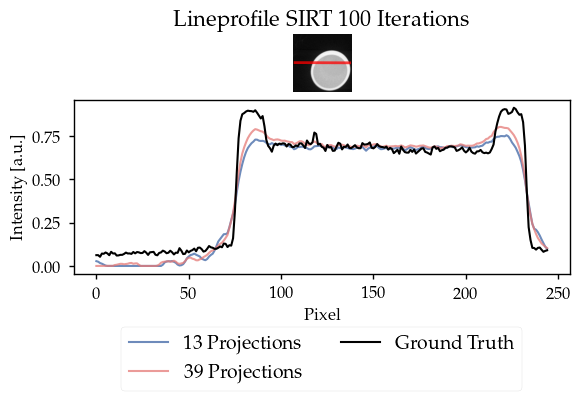

13 PSNR: 20.94
-0.33335805 0.20370442
39 PSNR: 22.05
-0.28812832 0.19644183


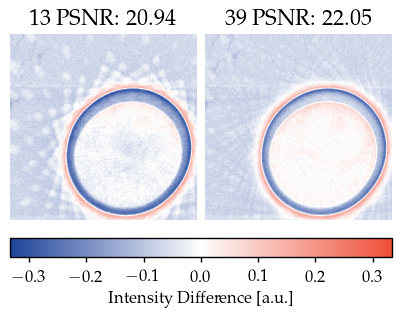

In [43]:
h=160
itgt_norm = (it_crossections["gt"][h] - np.min(it_crossections["gt"]) ) / (np.max(it_crossections["gt"]) - np.min(it_crossections["gt"]))
itin_norm = (it_crossections["13"][h] - np.min(it_crossections["13"]) ) / (np.max(it_crossections["13"]) - np.min(it_crossections["13"]))
itout_norm = (it_crossections["39"][h] - np.min(it_crossections["39"]) ) / (np.max(it_crossections["39"]) - np.min(it_crossections["39"]))

_, itpsin = evaluate( itgt_norm, itin_norm, normalise=False)
_,itpsout = evaluate(itgt_norm,itout_norm, normalise=False)

imgs = [itin_norm, itout_norm]
labels = ["13 Projections", "39 Projections"]
plot_line_profile(imgs, labels, itgt_norm, idxs= [128, 129, 10,255], folder="Hourglass4D", title="Lineprofile SIRT 100 Iterations", savefig=True, savefile="Hourglass4D_line_profile_SIRT")


plot_slice_grid(
    [-itgt_norm + itin_norm, -itgt_norm + itout_norm],
    [f"13 PSNR: {itpsin:.2f}", f"39 PSNR: {itpsout:.2f}"],
    bar=False,
    folder ="Hourglass4D",
    suptitle=None,
    savefig=True,
    two_sided=True,
    savefile="Hourglass4D_crossection_difference_SIRT",
    cm=XRDCT_diverging_cmp,
    fs=(1,1))



    
    


(256, 256)


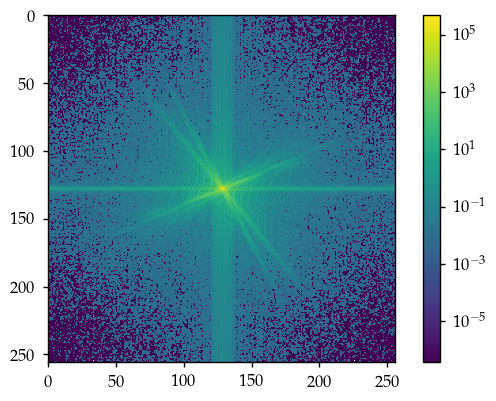

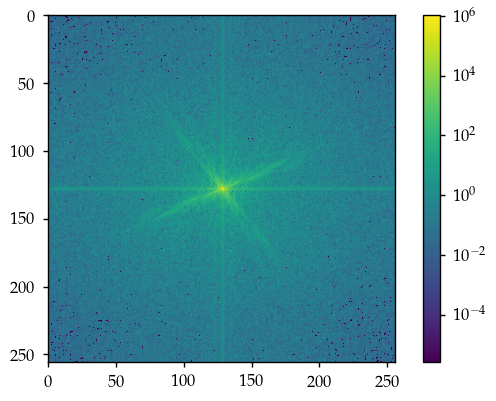

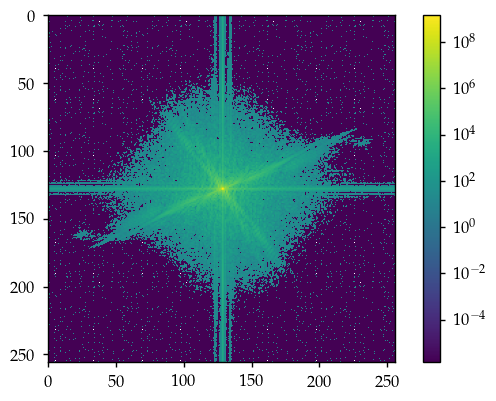

181.01933598375618
128
(1914,)


100%|██████████| 1914/1914 [00:00<00:00, 4174.24it/s]


(1914,)


100%|██████████| 1914/1914 [00:00<00:00, 5227.89it/s]


(1914,)


100%|██████████| 1914/1914 [00:00<00:00, 5273.29it/s]


(1914,)


100%|██████████| 1914/1914 [00:00<00:00, 4282.12it/s]


(1914,)


100%|██████████| 1914/1914 [00:00<00:00, 4874.10it/s]


(1914,)


100%|██████████| 1914/1914 [00:00<00:00, 4999.59it/s]


(1914,)


100%|██████████| 1914/1914 [00:00<00:00, 5060.43it/s]


(1914,)


100%|██████████| 1914/1914 [00:00<00:00, 4785.71it/s]


In [314]:
import scipy as sp
from matplotlib import colors
from tqdm import tqdm
import re

gt_k = sp.fft.fftshift(sp.fft.fftn(crossections["gt"][:,:,180]))
in_k = sp.fft.fftshift(sp.fft.fftn(crossections["13"][:,:,180]))
out_k = sp.fft.fftshift(sp.fft.fftn(crossections["13_enhanced"][:,:,180]))

print(gt_k.shape)

plt.imshow(np.abs(gt_k**2), norm = colors.LogNorm())
plt.colorbar()
plt.show()
plt.imshow(np.abs(in_k**2), norm = colors.LogNorm())
plt.colorbar()
plt.show()
plt.imshow(np.abs(out_k**2), norm = colors.LogNorm())
plt.colorbar()
plt.show()



X, Y = np.meshgrid(np.arange(256), np.arange(256))

radius = np.sqrt((X - 128)**2 + (Y - 128)**2).flatten()
print(radius.max())


def FSC(gt, elem, sizes= (256,256,256)):
    gt_k = sp.fft.fftshift(sp.fft.fftn(gt)).flatten()
    elem_k = sp.fft.fftshift(sp.fft.fftn(elem)).flatten()

    X, Y, Z = np.meshgrid(np.arange(sizes[0]), np.arange(sizes[1]), np.arange(sizes[2]))

    radius = np.sqrt((X - sizes[0]//2)**2 + (Y - sizes[1]//2)**2 + (Z-sizes[2]//2)**2).flatten()

    uniques = np.unique(radius)
    print(uniques.shape)

    FSCR = np.zeros_like(uniques, dtype=np.complex64)

    for i,u in enumerate(tqdm(uniques)):

        gt_kr = gt_k[np.where(radius == u)]
        elem_kr = elem_k[np.where(radius == u)]

        upper = np.sum(gt_kr * np.conj(elem_kr))

        lower = np.sqrt(np.sum(np.abs(gt_kr)**2) * np.sum(np.abs(elem_kr)**2))

        FSCR[i] = upper / lower

    return FSCR, uniques


fq_keys = ["13", "39", "65", "104"]

tot = 256
evsize = 64

X, Y, Z = np.meshgrid(np.arange(evsize), np.arange(evsize), np.arange(evsize))

radius = np.sqrt((X - evsize//2)**2 + (Y - evsize//2)**2 + (Z-evsize//2)**2).flatten()

uniques = np.unique(radius)




normalise = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

gt_3D = normalise(crossections["gt"])

ins_3D = {}
for k in fq_keys:
    ins_3D[k] = normalise(crossections[k])

outs_3D = {}
for k in fq_keys:
    outs_3D[k+"_enhanced"] = normalise(crossections[k+"_enhanced"])


# fscrs, uniquess 


print(tot//2)
outputs = [FSC(
    gt_3D[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2], 
    ins_3D[st][tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2], 
    sizes=(evsize,evsize,evsize)) for st in fq_keys ]

fq_keys_enhanced = ["13_enhanced", "39_enhanced", "65_enhanced", "104_enhanced"]
outputs_enhanced = [FSC(gt_3D[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2: tot//2+evsize//2], 
                        outs_3D[st][tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2], 
                        sizes=(evsize, evsize, evsize)) for st in fq_keys_enhanced ]



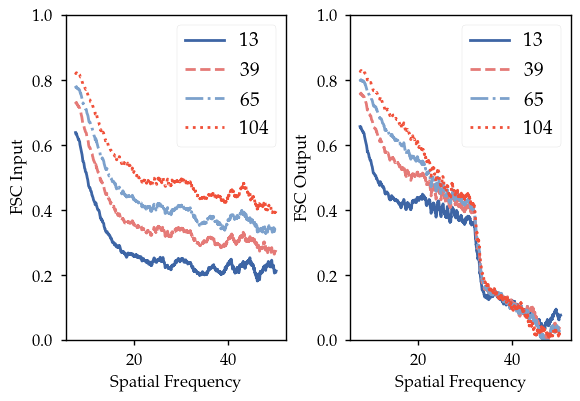

In [315]:
def plot_fsc(outputs, outputs_enhanced, uniques, fq_keys, filter = 50, ylabel1= "FSC Input", ylabel2="FSC Output", save=False, folder="Hourglass4D", savefile="FSC"):

    fig, (ax,axe) = plt.subplots(1,2)
    ax.set_xlabel("Spatial Frequency")
    ax.set_ylabel(ylabel1)
    # ax.set_xlim(0, 100)
    axe.set_xlabel("Spatial Frequency")
    axe.set_ylabel(ylabel2)

    for i, (fscr, uniques) in enumerate(outputs):
        # ax.plot(uniques, fscr.real, label="13 Projections")
        ax.plot(uniques[filter:-filter], [np.mean(fscr.real[i-filter:i+filter]) for i in range(filter, len(fscr.real)-filter)], label=fq_keys[i])       

    ax.legend()

    for i, (fscr, uniques) in enumerate(outputs_enhanced):

        axe.plot(uniques[filter:-filter], [np.mean(fscr.real[i-filter:i+filter]) for i in range(filter, len(fscr.real)-filter)], label=fq_keys[i])

    axe.legend()

    ax.set_ylim(0,1)
    axe.set_ylim(0,1)

    if save:
        plt.savefig(fr"../Results/{folder}/{savefile}.pdf", format="pdf")


    plt.show()

plot_fsc(outputs, outputs_enhanced, uniques, fq_keys, filter=50, ylabel1="FSC Input", ylabel2="FSC Output", save=False, folder="Hourglass4D", savefile="FSC_Hourglass4D_enhancement")


In [9]:
def evaluate(x,y, normalise=False):

    # Normalises between 0 and 1
    if normalise:
        x = (x- np.min(x)) / (np.max(x)-np.min(x))
        y = (y- np.min(y)) / (np.max(y)-np.min(y))

    ssim = utils.calc_ssim(x, y)
    psnr = utils.calc_psnr(x, y)
    return ssim, psnr

ssims = {}
psnrs = {}

x1, x2 = 0, 256
y1, y2 = 0, 256
z1, z2 = 0, 256

for k, v in crossections.items():
    if k == "gt":
        continue

    ss, ps = evaluate(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2], normalise=True)
    ssims[k] = ss #utils.calc_ssim(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2])
    psnrs[k] = ps #utils.calc_psnr(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2])

print(ssims)
print(psnrs)

{'13': 0.6031599019580697, '39': 0.7330793692301547, '65': 0.7664119556757191, '104': 0.8179948948148982, '13_enhanced': 0.7008183412875904, '39_enhanced': 0.7702584636348595, '65_enhanced': 0.7845029656578983, '104_enhanced': 0.8144576633233458}
{'13': 10.172998679275407, '39': 12.239623602657442, '65': 12.975349561561554, '104': 14.56366963407026, '13_enhanced': 11.466507807697191, '39_enhanced': 12.903520998711269, '65_enhanced': 13.202668725723601, '104_enhanced': 13.999541609262504}


In [266]:
def plot_attr_development(x, attrs, labels, xlabel="Projections", ylabel="SSIM", title="GAN Global Performance", folder="Hourglass4D", save=False, savefile="GAN_global_performance"):

    def proj_to_factor(x):
        return 256*np.pi/2 / x
        

    def factor_to_proj(x):
        return 256*np.pi/2 / x

    fig, ax = plt.subplots(1,1, )

    for attr, label in zip(attrs, labels):
        ax.plot(x, attr, "D:", label=label)
    # ax.plot(x, attrs, "D:", label=labels)

    ax2 = ax.secondary_xaxis('top', functions=(factor_to_proj, proj_to_factor)) #ax1.twiny()

    ax2.set_xlabel("Nyquist Undersampling Factor")
    ax2.set_xticks([2**i for i in range(1,6)])
    ax2.set_xticklabels([2**i for i in range(1,6)])

    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim([-20,20])
    ax.legend()
    ax.set_title(title)

    if save:
        plt.savefig(f"../Results/{folder}/{savefile}.pdf", format="pdf")
    
    plt.show()

[16.19113588  5.07163289  2.36048118 -0.43242709]
[12.71512136  5.42416513  1.75193094 -3.8735294 ]


C:\Users\Bruker\AppData\Local\Temp\ipykernel_20764\3899104746.py:4: RuntimeWarning: divide by zero encountered in divide
  return 256*np.pi/2 / x


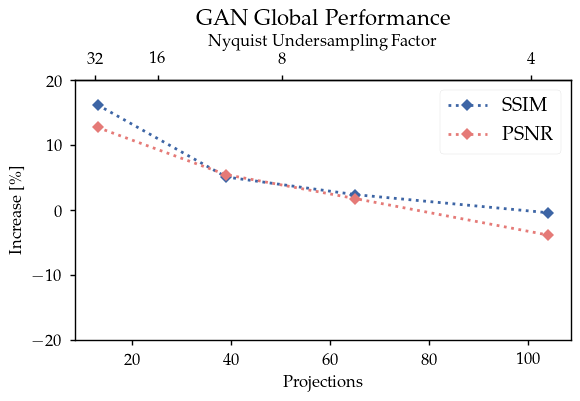

In [267]:
unenhanced = ssims["13"], ssims["39"], ssims["65"], ssims["104"]
enhanced = ssims["13_enhanced"], ssims["39_enhanced"], ssims["65_enhanced"], ssims["104_enhanced"]

increase = (np.array(enhanced) - np.array(unenhanced) )/ np.array(unenhanced)


unenhanced = psnrs["13"], psnrs["39"], psnrs["65"], psnrs["104"]
enhanced = psnrs["13_enhanced"], psnrs["39_enhanced"], psnrs["65_enhanced"], psnrs["104_enhanced"]

p_increase = (np.array(enhanced) - np.array(unenhanced) )/ np.array(unenhanced)

print(increase*100)
print(p_increase*100)

plot_attr_development([13,39,65,104], [increase*100, p_increase*100], ["SSIM", "PSNR" ], xlabel="Projections", ylabel="Increase [\%]", title="GAN Global Performance", folder="Hourglass4D", save=True, savefile="GAN_global_performance")
